### Building blocks view of aggregated events in long-term mositure 

In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dask.array as da
from scipy.ndimage import gaussian_filter
from scipy import interpolate
from scipy.stats import linregress

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.ndimage.filters import uniform_filter1d

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind

In [2]:
os.chdir('/data2/willytsai/python_module/')
import SCAI_calc4obj as scai 

In [3]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N
    y_avg = np.convolve(y, avg_mask, 'same')
    return y_avg

In [5]:
warnings.filterwarnings('ignore')

In [16]:
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/data2/willytsai/MERRA2/'
MERRA2_3d_dir = '/data/willytsai/'
ERA5_dir = '/data/willytsai/ERA5/'
Gridsat_dir = '/data/willytsai/gridsat_BT/remap_0.1deg/'
fig_dir = '/data/willytsai/ISCCP/fig/'

#### Read data: cwv, precp, BT 

In [17]:
def SCAI_index_bt(bt_sm,cri_val=240):

    N_psT = np.zeros(bt_sm.shape[0]) # BT_based
    SCAI_BT = np.zeros(bt_sm.shape[0]) # cldfrac over domain by BT criteria
    
   # N and SCAI indices
    for t in range(bt_sm.shape[0]):
        label_obj, N = scai.labeled_obj(bt_sm[t,:,:],cri=cri_val,flag=2) # less than 240 K
        label_new, num_new = scai.label_remove(label_obj, N, connect_min=3) # remove obj with pixel numb. < 3
        SCAI_BT[t] = scai.SCAI_calc(label_new,num_new,dx=0.1*100000,L=5*100000)
        N_psT[t] = num_new

    return (SCAI_BT,N_psT)

In [42]:
# read MERRA2 CWV
os.chdir(MERRA2_dir+'inst_2d_hourly/')
files = sorted(glob('*2014*')+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*'))

for n in range(len(files)):
    ds = xr.open_dataset(files[n])
    data = ds.sel(lat=slice(0,5),lon=slice(60,65)).TQV.resample(time='3H').nearest()
    if n == 0:
        cwv_sm = data
    else:
        cwv_sm = np.concatenate([cwv_sm,data],axis=0)

In [22]:
# read TRMM prec
os.chdir(TRMM_dir+'2009_2018')
files = sorted(glob('*2014*')+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*'))

for n in range(len(files)):
    ds = xr.open_dataset(files[n])
    data = ds.sel(nlat=slice(0,5),nlon=slice(60,65)).precipitation
    if n == 0:
        prec_sm = data
    else:
        prec_sm = np.concatenate([prec_sm,data],axis=0)
prec_sm = prec_sm.reshape((14608,20,20))

In [23]:
# read Gridsat BT
os.chdir(Gridsat_dir+'2009_2018')
files = sorted(glob('*2014*')+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*'))

for n in range(len(files)):
    ds = xr.open_dataset(files[n])
    data = ds.sel(lat=slice(0,5),lon=slice(60,65)).irwin_cdr
    if n == 0:
        bt_sm = data
    else:
        bt_sm = np.concatenate([bt_sm,data],axis=0)
bt_sm = bt_sm.reshape((14608,50,50))

In [24]:
# calculate SCAI 
SCAI_BT,N_psT = SCAI_index_bt(bt_sm,cri_val=240)

Text(0.5, 0, '[hour]')

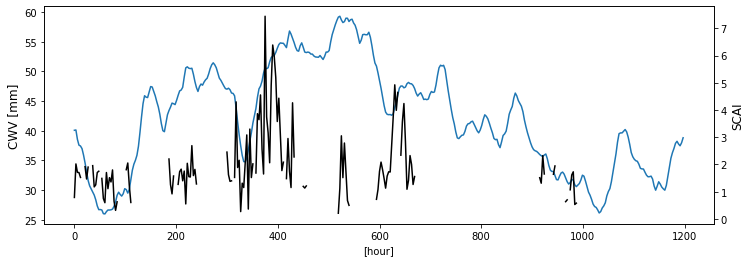

In [25]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(3*np.arange(400),np.nanmean(cwv_sm[:400,:,:],axis=(1,2)))
ax2 = ax.twinx()
ax2.plot(3*np.arange(400),SCAI_BT[:400],'k')
ax.set_ylabel('CWV [mm]',fontsize=12)
ax2.set_ylabel('SCAI',fontsize=12)
ax.set_xlabel('[hour]')

In [44]:
cwv_mn = cwv_sm.mean(axis=(1,2))
prec_mn = prec_sm.mean(axis=(1,2))

In [45]:
# 1 day running mean of CWV
cwv_1drm = running_mean(cwv_mn,8)
cwv_2drm = running_mean(cwv_mn,16)
cwv_5drm = running_mean(cwv_mn,40)
cwv_10drm = running_mean(cwv_mn,80)
cwv_1ddt = 24*np.gradient(cwv_1drm,3) # [mm/d]

SCAI_10drm = running_mean(SCAI_BT,80)

In [46]:
# find identified event
date = []; date_begin = datetime(2014,1,1)
for t in range(14608):
    tmp = date_begin + t*timedelta(hours=3)
    date.append(tmp)

t_event = []
t_all = np.where(24*prec_mn>5)[0] # averaged rainfall > 5 mm/day
t_all = t_all[np.logical_and(t_all > 16,t_all < len(date)-17)] 
for t in t_all:
    p_window = prec_mn[t-16:t+17]
    if p_window.max() == p_window[16]: # prec max within 2d
        t_event.append(t)        
t_event = np.asarray(t_event)

In [47]:
SCAI_BT_event = np.copy(SCAI_BT)*np.nan
SCAI_BT_event[t_event] = SCAI_BT[t_event]

(0.0, 4.0)

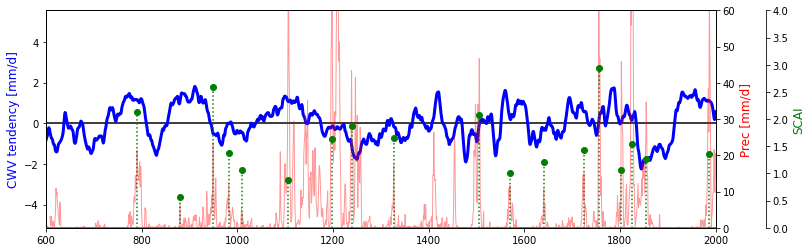

In [48]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
#ax.plot(cwv_2drm,'-b')
#ax.plot(cwv_5drm,'--b',linewidth=3)
#ax.plot(cwv_10drm,'-b',linewidth=3)
ax.plot(24*np.gradient(cwv_10drm,3),'-b',linewidth=3)

#ax.plot(cwv_mn,'k',alpha=0.5,linewidth=1)
ax2 = ax.twinx()
ax2.plot(24*prec_mn,color='r',alpha=0.4,linewidth=1)
ax3 = ax.twinx()
ax.plot(np.gradient(SCAI_10drm,3),'-g',linewidth=3)
ax3.stem(SCAI_BT_event, markerfmt='og',linefmt=':g')

ax.set_ylabel('CWV tendency [mm/d]',color='b',fontsize=12)
ax2.set_ylabel('Prec [mm/d]',color='r',fontsize=12)
ax3.set_ylabel('SCAI',color='g',fontsize=12)
ax3.spines['right'].set_position(('outward', 50))      
#ax3.xaxis.set_ticks([])
ax.hlines(y=0,xmin=600,xmax=2000,color='k')

ax.set_xlim([600,2000])
#ax.set_ylim([30,60])
ax2.set_ylim([0,60])
ax3.set_ylim([0,4])

In [49]:
cwv_bin = np.linspace(30,65,21)
cwvdt_bin = np.linspace(-10,10,21)

In [50]:
SCAIbin = np.zeros((len(cwv_bin)-1,len(cwvdt_bin)-1))

for i in range(len(cwv_bin)-1):
    idx = np.where(np.logical_and(cwv_1drm>=cwv_bin[i],cwv_1drm<cwv_bin[i+1]))
    for j in range(len(cwvdt_bin)-1):
        idy = np.where(np.logical_and(cwv_1ddt>=cwvdt_bin[j],cwv_1ddt<cwvdt_bin[j+1]))
        
        idx_com = np.intersect1d(idx,idy)
        SCAIbin[i,j] = np.nanmean(SCAI_BT[idx_com])

(-12.0, 12.0)

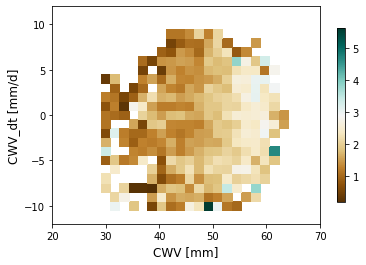

In [51]:
plt.pcolormesh(cwv_bin[:-1],cwvdt_bin[:-1],SCAIbin.T,shading='nearest',cmap='BrBG')
plt.colorbar(shrink=0.8)
plt.ylabel('CWV_dt [mm/d]',fontsize=12)
plt.xlabel('CWV [mm]',fontsize=12)
plt.xlim([20,70])
plt.ylim([-12,12])

(29216,)